In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_ENABLE_CUDNN_OPTS'] = '1'
os.environ['DEEPREG_LOG_LEVEL'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout, Reshape
from tensorflow.keras import ops, activations
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



# used for segmentation_models
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm



Segmentation Models: using `tf.keras` framework.


In [2]:
# Load the data file

# Define the path for the datasets
path_images = os.path.join("data/images")
path_masks = os.path.join("data/masks")
path_val_image = os.path.join("data/val_image")
path_val_mask = os.path.join("data/val_mask")

# Create lists with file names
list_path_images = os.listdir(path_images)
list_path_masks = os.listdir(path_masks)
list_path_val_image = os.listdir(path_val_image)
list_path_val_mask = os.listdir(path_val_mask)

# Sort the lists(os.listdir - does not order the returned result)
list_path_images.sort()
list_path_masks.sort()
list_path_val_image.sort()
list_path_val_mask.sort()

print(path_images)
print(list_path_images)

data/images
['136_00090.png', '136_00210.png', '136_00420.png']


In [3]:
# Create the database loading and pre-processing function

def load_resize_dataset(path_image_dataset, path_masks_dataset, list_path_img, list_path_mas, WIDTH, HEIGHT):

    list_images = []
    list_masks = []

    for path_image, path_masks in zip(list_path_img, list_path_mas):

        # Define the path
        path_image = path_image_dataset + '/' + path_image
        path_masks = path_masks_dataset + '/' + path_masks

        # Upload image
        image = cv2.imread(path_image, cv2.IMREAD_COLOR) # IMREAD_COLOR, IMREAD_GRAYSCALE, IMREAD_UNCHANGED
        mask = cv2.imread(path_masks, cv2.IMREAD_GRAYSCALE) # IMREAD_COLOR,IMREAD_GRAYSCALE, IMREAD_UNCHANGED
    
        # Set the desired resolution
        dim_image = (WIDTH, HEIGHT)
        image = cv2.resize(image, dim_image, interpolation = cv2.INTER_AREA)
        mask = cv2.resize(mask, dim_image, interpolation = cv2.INTER_AREA)

        # Add a channel '1' to the mask to have a structure similar to image
        mask = np.reshape(mask, (HEIGHT, WIDTH, 1))

        # Add image and mask to lists
        list_images.append(image)
        list_masks.append(mask)

        # Destroy the object
        cv2.destroyAllWindows()

    # to array
    images_array = np.asarray(list_images, dtype=np.uint8)
    masks_array = np.asarray(list_masks, dtype=np.uint8)

    return images_array, masks_array

In [4]:
# Define the desired resolution
WIDTH, HEIGHT = 512, 1024 

In [5]:
# Create the training dataset
train_x, train_y = load_resize_dataset(path_images, path_masks, list_path_images, list_path_masks, WIDTH, HEIGHT)
# Normalize the dataset
train_x = tf.cast(train_x , tf.float32) / 255.0 # am impartite la 255 deoarece imaginea e in 8 bit adica 256 de valori
# mask has values of 0 and 1
train_y = tf.cast(train_y > 0, tf.float32) 

print(train_x.shape)
print(train_y.shape)

(3, 1024, 512, 3)
(3, 1024, 512, 1)


In [6]:
# Create the data set for validation
val_x, val_y = load_resize_dataset(path_val_image, path_val_mask, list_path_val_image, list_path_val_mask, WIDTH, HEIGHT)
# Normalize the data set
val_x = tf.cast(val_x , tf.float32) / 255.0
# mask has values of 0 and 1
val_y = tf.cast(val_y > 0 , tf.float32)

print(val_x.shape)
print(val_y.shape)

(10, 1024, 512, 3)
(10, 1024, 512, 1)


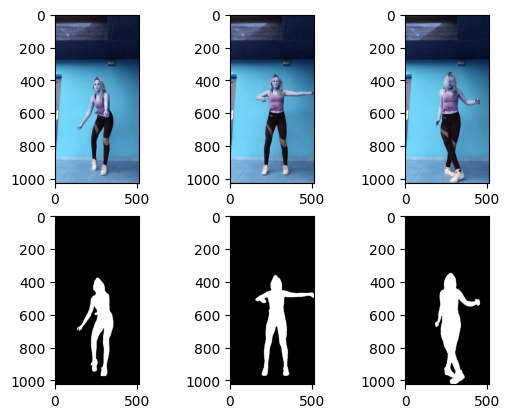

In [7]:

# These 3 images are the training dataset. !!!

plt.figure()

plt.subplot(2, 3, 1)
plt.imshow(train_x[0])
plt.subplot(2, 3, 2)
plt.imshow(train_x[1])
plt.subplot(2, 3, 3)
plt.imshow(train_x[2])

plt.subplot(2, 3, 4)
plt.imshow(train_y[0])
plt.gray()
plt.subplot(2, 3, 5)
plt.imshow(train_y[1])
plt.gray()
plt.subplot(2, 3, 6)
plt.imshow(train_y[2])
plt.gray()

plt.savefig('training_data.png')

plt.show()

In [8]:
# Transform the dataset into a tensor
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)) 
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y)) 

In [9]:
# Create batches
# In this case, all images are included in a single batch.
batch_size = 3
train_dataset = train_dataset.batch(batch_size) 
val_dataset = val_dataset.batch(batch_size) 

In [10]:
# Configuring the dataset for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Encoder SegNet

def enc_layer(enc_inputs, number_filters,kernel):

    enc_conv_1 = Conv2D(number_filters, kernel_size=(kernel, kernel),strides=(2, 2), padding="same", kernel_initializer='he_normal')(enc_inputs)  
    enc_conv_1 = activations.swish(enc_conv_1)

    enc_conv_1 = Dropout(0.1)(enc_conv_1)
    
    enc_conv_2 = Conv2D(number_filters, kernel_size=(kernel, kernel),strides=(1, 1), padding="same", kernel_initializer='he_normal')(enc_conv_1) 
    enc_conv_2 = activations.swish(enc_conv_2)

    enc_conv_2 = Dropout(0.25)(enc_conv_2)

    return enc_conv_2
    

In [12]:
# Decoder layer SegNet

def dec_layer(dec_inputs, number_filters, kernel):

    dec_unpool = UpSampling2D(size=(2, 2), data_format="channels_last")(dec_inputs)

    dec_conv_1 = Conv2D(number_filters, kernel_size=(kernel, kernel),strides=(1, 1), padding="same", kernel_initializer='he_normal')(dec_unpool)  
    dec_conv_1 = activations.swish(dec_conv_1)

    dec_conv_1 = Dropout(0.1)(dec_conv_1)

    dec_conv_2 = Conv2D(number_filters, kernel_size=(kernel, kernel),strides=(1, 1), padding="same", kernel_initializer='he_normal')(dec_conv_1) 
    dec_conv_2 = activations.swish(dec_conv_2)

    dec_conv_2 = Dropout(0.25)(dec_conv_2)

    return dec_conv_2

In [13]:
# Define the number of filters for each layer
nr_filters_1 = 4
nr_filters_2 = nr_filters_1 * 8
nr_filters_3 = nr_filters_2 * 8

In [14]:
# Encoder block
encoder_inputs = Input(shape=(train_x.shape[1:]))
enc_layer_1 = enc_layer(encoder_inputs, nr_filters_1, 3)
enc_layer_2 = enc_layer(enc_layer_1, nr_filters_2, 3)
encoder_outputs = enc_layer(enc_layer_2, nr_filters_3, 3)

In [15]:
print(encoder_inputs.shape)
print(enc_layer_1.shape)
print(enc_layer_2.shape)
print(encoder_outputs.shape)

(None, 1024, 512, 3)
(None, 512, 256, 4)
(None, 256, 128, 32)
(None, 128, 64, 256)


In [16]:
# Decoder block
dec_layer_1 = dec_layer(encoder_outputs, nr_filters_3, 3)
dec_layer_2 = dec_layer(dec_layer_1, nr_filters_2, 3)
dec_layer_3 = dec_layer(dec_layer_2, nr_filters_1, 3)

# This convolutional layer converts the output data matrix from the decoder into a form 
# identical to the label form (1024, 512, 1 in dis case).
decoder_outputs = Conv2D(1, kernel_size=(1, 1), padding="same", kernel_initializer='he_normal')(dec_layer_3)
decoder_outputs = activations.sigmoid(decoder_outputs)


In [17]:
print(dec_layer_1.shape)
print(dec_layer_2.shape)
print(dec_layer_3.shape)
print(decoder_outputs.shape)

(None, 256, 128, 256)
(None, 512, 256, 32)
(None, 1024, 512, 4)
(None, 1024, 512, 1)


In [18]:
#  Define the model
autoencoder_model = Model(encoder_inputs, decoder_outputs)
# Summarize the model
autoencoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024, 512, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 256, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ silu (Silu)                     │ (None, 512, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 256, 4)    │           148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ silu_1 (Silu)                   │ (None, 512, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 128, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ silu_2 (Silu)                   │ (None, 256, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ silu_3 (Silu)                   │ (None, 256, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 64, 256)   │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ silu_4 (Silu)                   │ (None, 128, 64, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128, 64, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 64, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ silu_5 (Silu)                   │ (None, 128, 64, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128, 64, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 256, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ silu_6 (Silu)                   │ (None, 256, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ silu_7 (Silu)                   │ (None, 256, 128, 256)  │             

 Total params: 1,939,233 (7.40 MB)

 Trainable params: 1,939,233 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Create the loss function
def loss_value(y_true, y_pred):

    # Dice Loss is a specialized loss function used in image segmentation, 
    # which quantifies the overlap between a predicted segmentation mask and its true shape.
    # Dice Loss = 1-(2 * |A ∩ B|) / (|A| + |B|)
    # A - number of pixels y_true
    # B - number of pixels y_pred
    dice_loss = sm.losses.DiceLoss()

    # CategoricalFocalLoss este o varianta modificata a functiei Cross-Entropy Loss, 
    # CategoricalFocalLoss is a modified version of the Cross-Entropy Loss function, 
    # which returns the Cross-Entropy loss value in a dynamic way 
    # CategoricalFocalLoss = alpha * (1 - p_t) ** gamma * CrossEntropy(y_true, y_pred)
    # p_t = output if y_true == 1, else 1 - output
    # gamma focus parameter
    focal_loss = sm.losses.CategoricalFocalLoss()

    # Insumarea functiilor de pierdere
    total_loss = dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)

    return total_loss



In [20]:
# Create the prediction evaluation function 
def metric(y_true, y_pred):

    # Apply the value 0 or 1 to the data resulting from the model prediction,
    # by applying a threshold
    threshold = 0.5
    y_pred = tf.where(y_pred > threshold, 1, y_pred)
    y_pred = tf.where(y_pred <= threshold, 0, y_pred)

    # Call the metric function
    metric_acu = tf.keras.metrics.Accuracy(name='accuracy')
    metric = metric_acu(y_true, y_pred)

    return metric.numpy()  


In [21]:
# Call the optimization function
autoencoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

# The optimization function
def train_step(x, y):   

    # Create a Gradient Tape object
    with tf.GradientTape() as autoencoder_grad:

        # Call the model with the option training=True (in the case of training=False, Dropout does not work)
        autoencoder_rezult = autoencoder_model(x, training=True)
        # Returns the loss value
        loss_ = loss_value(y,autoencoder_rezult)

    # CCombine loss and gradient values into an object
    autoencoder_gradients = autoencoder_grad.gradient(loss_, autoencoder_model.trainable_weights)
    # AApply gradient optimization
    autoencoder_optimizer.apply_gradients( zip( autoencoder_gradients, autoencoder_model.trainable_weights))


In [22]:
# Custom fit()

epochs = 500

train_loss_values=[]
val_loss_values=[]

train_metric_values=[]
val_metric_values=[]

progres_larning = []


for i in range(epochs):

    # Display the current era
    print("epoch: ", str(i+1), f"/ {str(epochs)}" )
    
    train_batch_loss = []
    train_batch_metric = []

    # Define the progress bar object
    progbar_train = tf.keras.utils.Progbar(len(train_dataset), unit_name = 'Training')

    # Iterate through the dataset for training to extract the training batches (train_dataset) 
    # and separate them into features and labels (x_train_batch, y_train_batch)
    # step_train - used for the progress bar step
    for step_train, (x_train_batch, y_train_batch) in enumerate(train_dataset):

        # Incrementeaza un pas in bara de progres
        progbar_train.update(step_train+1)

        # Call the training step
        train_current_loss = train_step(x_train_batch, y_train_batch)

        # Returns the model prediction for the current batch
        train_predict = autoencoder_model(x_train_batch,training=False)


        # Determine the loss on the current batch
        train_current_loss = loss_value(y_train_batch, train_predict)
        train_batch_loss.append(train_current_loss)

        # Measures the efficiency of the model on the current batch
        train_current_metric = metric(y_train_batch, train_predict)
        train_batch_metric.append(np.mean(train_current_metric))



        # Records the evolution of predictions during training
        if (i % 50) == 0:
            progres_larning.append(train_predict)
        
    # Creaza liste cu evolutiile loss si metric, pe parcursul perioadei de antrenament     
    train_loss_values.append(np.mean(train_batch_loss))
    train_metric_values.append(np.mean(train_batch_metric))

    # Afiseaza loss si metric pentru epoca curenta
    print("loss train_set", str(np.mean(train_batch_loss)))
    print("metric train_set", str(np.mean(train_batch_metric)))



    # Similar to the descriptions above, predictions for the validation dataset are addressed. 
    
    val_batch_loss = []
    val_batch_metric = []
    
    progbar_val = tf.keras.utils.Progbar(len(val_dataset), unit_name = 'Validation') 
    for step_val, (x_val_batch, y_val_batch) in enumerate(val_dataset):

        progbar_val.update(step_val+1)
        
        val_predict = autoencoder_model(x_val_batch,training=False)
        
        val_current_loss = loss_value(y_val_batch,val_predict)
        val_batch_loss.append(val_current_loss)

        val_current_metric = metric(y_val_batch, val_predict)
        val_batch_metric.append(np.mean(val_current_metric))
        
    val_loss_values.append(np.mean(val_batch_loss))
    val_metric_values.append(np.mean(val_batch_metric))

    print("loss val_set", str(np.mean(val_batch_loss)))
    print("metric val_set", str(np.mean(val_batch_metric)))    
    print()



epoch:  1 / 500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/Training
loss train_set 0.8233915
metric train_set 0.8541247
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/Validation
loss val_set 0.8308951
metric val_set 0.85787755

epoch:  2 / 500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/Training
loss train_set 0.8227439
metric train_set 0.8807437
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/Validation
loss val_set 0.8302599
metric val_set 0.884545

epoch:  3 / 500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/Training
loss train_set 0.8213452
metric train_set 0.89864224
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/Validation
loss val_set 0.82887113
metric val_set 0.9034516

epoch:  4 / 500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/Training
loss train_set 0.8180431
metric train_set 0.9033534
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/Validation
loss val_set 0.82554984
metric val_set 0.90812445

epoch:  5 / 500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/Training
loss train_set 0.8102593
metric train_set 0.9065793
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/Validation
loss val_set 0.8177829
metric val_

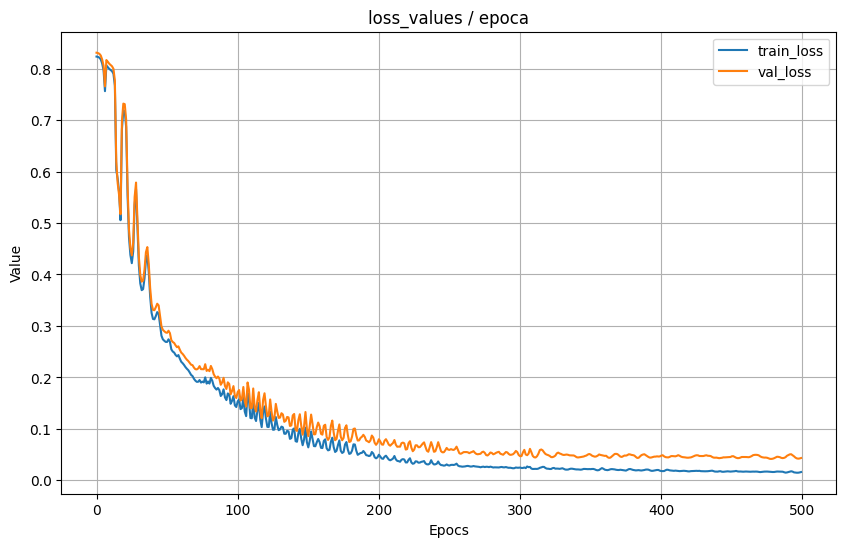

In [23]:
# Shows the evolution of losses during training
plt.figure(figsize=(10,6)) 
plt.plot(train_loss_values, label = 'train_loss')
plt.plot(val_loss_values, label = 'val_loss')
plt.legend() 
plt.title('loss_values / epoca')
plt.xlabel('Epocs')
plt.ylabel('Value')
plt.grid()
plt.savefig('loss.png')
plt.show()

Evolution of predictions during training


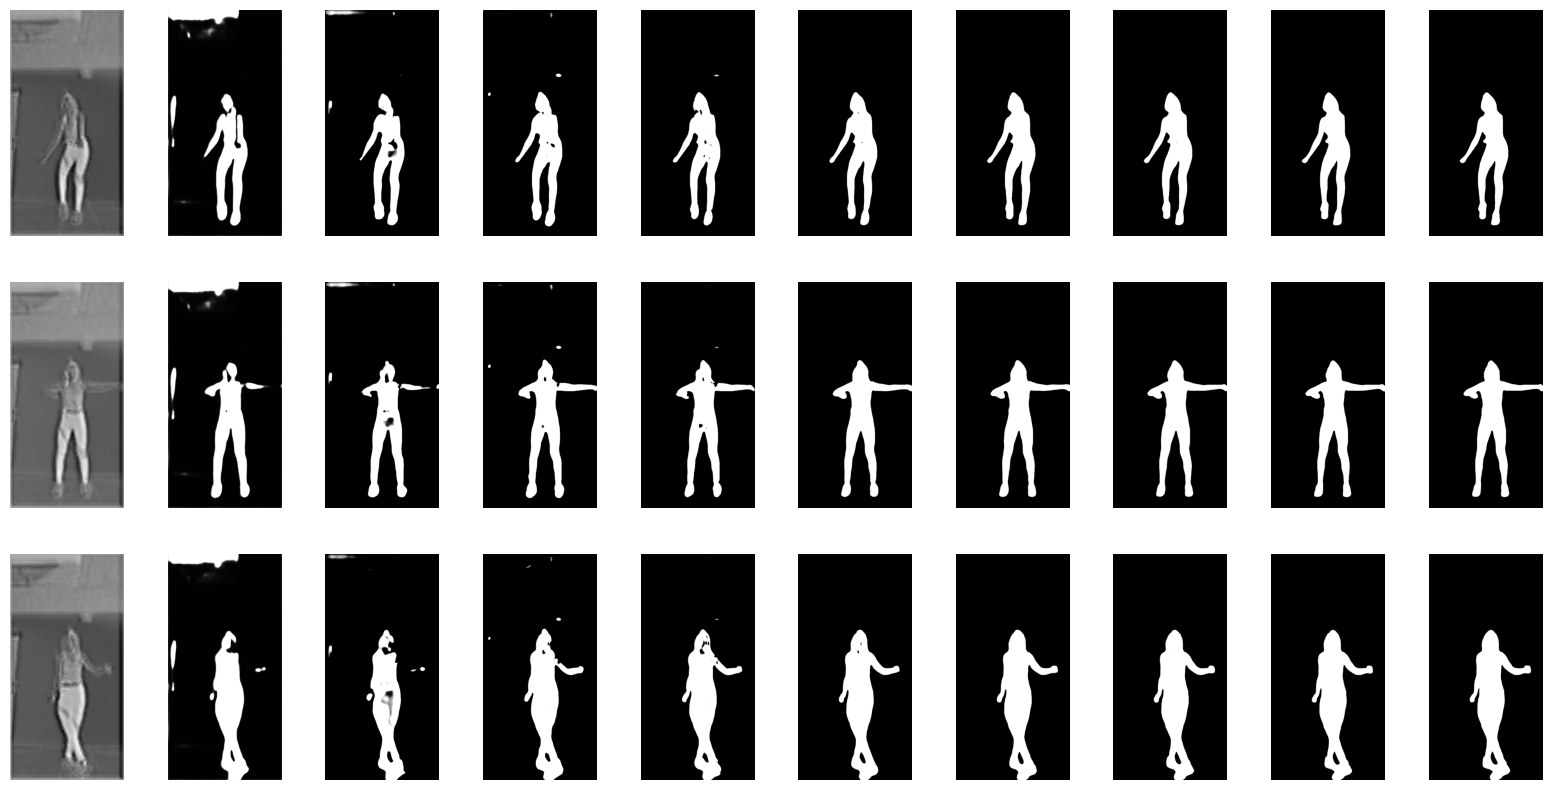

In [24]:
# Evolution of predictions during training
col = len(progres_larning) 
n=0
print('Evolution of predictions during training')
plt.figure(figsize = (20, 10))
for i in range(0,col,1):
    
    plt.subplot(3, col, n + 1)
    plt.imshow(progres_larning[i][0])
    plt.gray()
    plt.axis('off')
    
    plt.subplot(3, col, n + col + 1)
    plt.imshow(progres_larning[i][1])
    plt.gray()
    plt.axis('off')
    
    plt.subplot(3, col, n + (2 * col) + 1)
    plt.imshow(progres_larning[i][2])
    plt.gray()
    plt.axis('off')
    
    n+=1

plt.savefig('evolution.png')
plt.show()

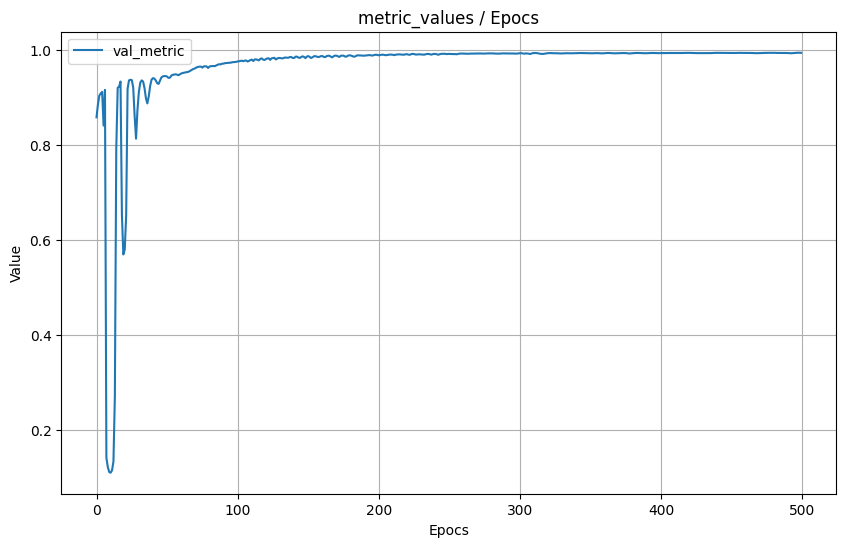

In [25]:
# # Evolution of metric during training 
plt.figure(figsize=(10,6)) 
plt.plot(val_metric_values, label = 'val_metric')
plt.legend() 
plt.title('metric_values / Epocs')
plt.xlabel('Epocs')
plt.ylabel('Value')
plt.grid()
plt.savefig('metric.png')
plt.show()

In [26]:
# Generate model predictions for test data (in this case, validation data is used)
with tf.device("/CPU:0"):
    y_probs = autoencoder_model(val_x, training=False)

# Aplica valoarea de 0 sau 1 datelor rezultate din predictia modelului,
# prin aplicarea unui prag de delimitare
threshold = 0.5
y_probs = tf.where(y_probs > threshold, 1, y_probs)
y_probs = tf.where(y_probs <= threshold, 0, y_probs)

# Evidentiaza predictia si masck, suprapuse pe imaginea de intrare in model
predict_y = (0.4 * val_x) + (0.6 * y_probs)
true_y = (0.4 * val_x) + (0.6 * val_y)

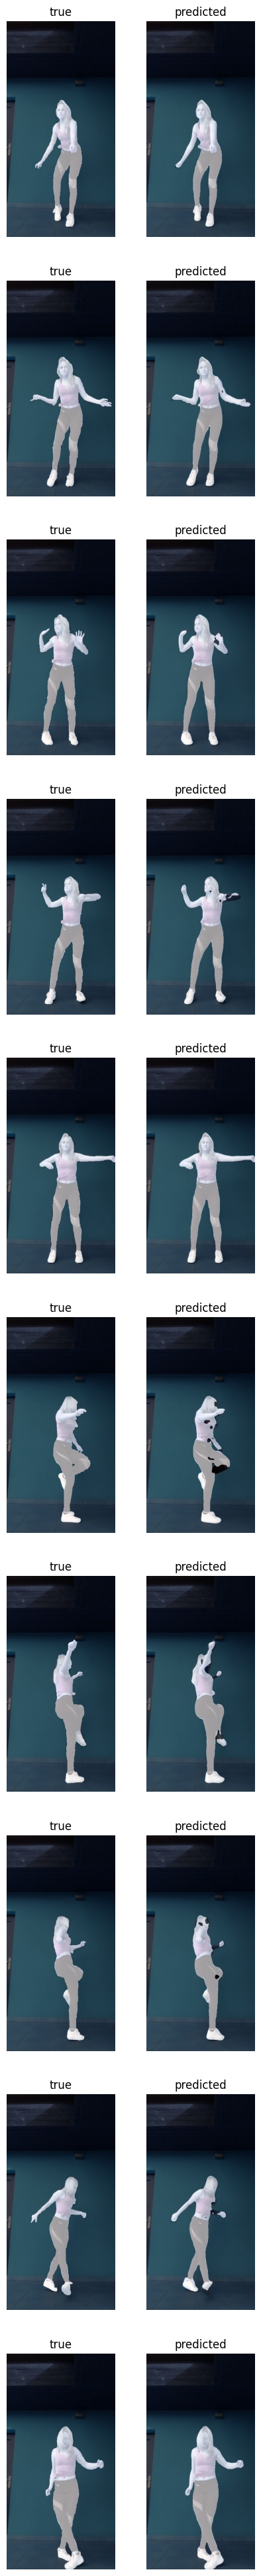

In [27]:
# Show predictions compared with reality

row = len(val_x)

plt.figure(figsize = (5, 50))
n = 0
for i in range(0, row, 1):
    
    plt.subplot(row, 2, n + 1)
    plt.imshow(true_y[i])
    plt.title('true')
    plt.axis('off')

    plt.subplot(row, 2, n + 2 )
    plt.imshow(predict_y[i])
    plt.title('predicted')
    plt.axis('off')
    
    n += 2

plt.savefig('comparations.png')
plt.show()

In [28]:
# Save model
tf.keras.models.save_model(model = autoencoder_model, filepath='SegNet.keras', overwrite=True)

In [29]:
# Save checkpoint weights
autoencoder_model.save_weights(filepath='./weights_checkpoint/autoencoder_checkpoint.weights.h5',overwrite=True)